# Dataset exploration

---

**Importing necessary python packages**

In [148]:
import IPython
import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jams
import os

**Size of the GuitarSet**

In [226]:
sizes = dict()

root = '../data/raw/'

for dir in os.listdir(root):
    size = 0
    if dir != '.DS_Store':
        for f in os.listdir(root+dir):
            size += os.path.getsize(root+dir+'/'+f)

        sizes[dir] = np.round(size / 1e6, 2)

for key, val in sizes.items():
    print(f"Folder {key} is {val} MB")

Folder audio_mono-pickup_mix is 967.43 MB
Folder audio_mono-mic is 967.43 MB
Folder audio_hex-pickup_original is 5804.53 MB
Folder annotation is 569.35 MB
Folder audio_hex-pickup_debleeded is 5804.52 MB


## Annotations

**Importing annotation data**

Annotations are saved in *\*.jams* files. See [here](http://marl.smusic.nyu.edu/papers/humphrey_jams_ismir2014.pdf) for documentation/paper and [here](https://github.com/marl/jams) for the repo.

In [149]:
# get list of file names in folder
def load_file_names(dir: str = '../data/raw/annotation/') -> list:
    # create empty list
    filenames = []

    # go through directory and append path+file name to list
    for f in os.listdir(dir):
        filenames.append(dir+f)
    return filenames


# loading jams file for song
def load_jams_file(f: str or list) -> jams.core.JAMS:
    # return jams structure
    return jams.load(f)


# accessing single pickups:
def load_time_freq_data(j: jams.core.JAMS, namespace: str = 'pitch_contour') -> pd.DataFrame:
    # E2–A2–D3–G3–B3–E4
    stringMap = {0: 'E', 1: 'A', 2: 'D', 3: 'G', 4: 'H', 5: 'e'}

    # create empty dataframe
    df = pd.DataFrame()

    # load all played frequencies and timings for all 6 strings
    for i in range(6):
        data = pd.DataFrame(j.annotations[namespace][i])
        freq = pd.json_normalize(data['value'])['frequency']
        temp = pd.concat([data['time'], freq], axis=1)
        temp['string'] = stringMap[i]
        df = pd.concat([df, temp], axis=0)

    return df

In [152]:
files = sorted(load_file_names())
n_file = 1
jams_file = load_jams_file(files[n_file])
song_df = load_time_freq_data(jams_file).sort_values(by='time', ascending=True)

**What data are in the \*.jams files?**

In [186]:
jams_file.keys()
jams_file['annotations']


[17 annotations]

In [191]:
import json
import pprint

data = json.load(open('../data/raw/annotation/00_BN1-129-Eb_solo.jams', 'rb'))
pprint.pprint(data, depth=4)

{'annotations': [{'annotation_metadata': {'annotation_rules': '',
                                          'annotation_tools': '',
                                          'annotator': {},
                                          'corpus': '',
                                          'curator': {...},
                                          'data_source': '0',
                                          'validation': '',
                                          'version': ''},
                  'data': {'confidence': [...],
                           'duration': [...],
                           'time': [...],
                           'value': [...]},
                  'duration': 22.32439999999997,
                  'namespace': 'pitch_contour',
                  'sandbox': {},
                  'time': 543.742},
                 {'annotation_metadata': {'annotation_rules': '',
                                          'annotation_tools': '',
                                   

In [192]:
jams.list_namespaces()

NAME                          	DESCRIPTION                             
------------------------------------------------------------------------------
beat                          	Beat event markers with optional metrical po..
beat_position                 	Tuples of (position, measure, beats per meas..
blob                          	Binary object (blob)                    
chord                         	Expanded chord set. Includes: X, sus2, 1, 5,..
chord_harte                   	Chord annotations following Harte et al., 20..
chord_roman                   	Roman numeral chords: (tonic, chord)    
key_mode                      	Key and optional mode (major/minor or Greek ..
lyrics                        	Open strings for lyrics annotations     
lyrics_bow                    	Bag of words or n-grams                 
mood_thayer                   	Thayer mood model: (valence, arousal)   
multi_segment                 	Multi-level segmentation: (label, level)
note_hz                    

**How many annotations do we have? How many are compositions (backing tracks) and how many are solos?**

In [228]:
n_annot = len(files)
n_solo = 0
n_comp = 0
n_c = 0
for f in files:
    if 'solo' in f: n_solo += 1
    elif 'comp' in f: n_comp += 1
    if '-C_' in f: n_c +=1

print(f"There are {n_annot} annotation files, split into {n_solo} solos and {n_comp} backing tracks. They are distributed over 5 different genres:")
print("Bossa Nova, Funk, Jazz, Rock, Singer Songwriter")
print(f"{n_c/2} songs are in C")

There are 360 annotation files, split into 180 solos and 180 backing tracks. They are distributed over 5 different genres:
Bossa Nova, Funk, Jazz, Rock, Singer Songwriter
24.0 songs are in C


In [155]:
song_df.head(10)

,time,frequency,string
0,0.011288,116.450,E
0,0.014349,210.364,D
1,0.017093,116.089,E
1,0.020154,210.163,D
0,0.020857,158.061,A
2,0.022898,116.279,E
2,0.025959,209.846,D
1,0.026662,157.854,A
3,0.028703,116.688,E
3,0.031764,209.857,D


**Visualizing annotation data**

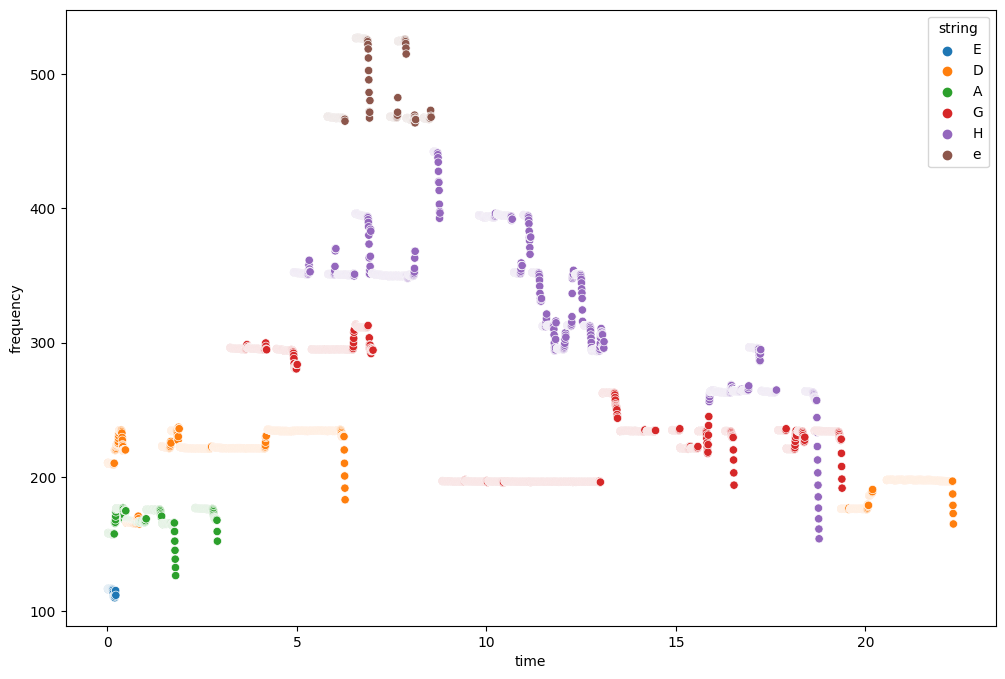

In [174]:
fig, _ = plt.subplots(figsize=(12, 8))

# displaying frequencies played on high e string over time
sns.scatterplot(data=song_df, x='time', y='frequency', hue='string');

## Audio files

**Importing and visualizing corresponding audio data**

For further information see [here](https://www.kdnuggets.com/2020/02/audio-data-analysis-deep-learning-python-part-1.html)

In [ ]:
file = '../data/raw/audio_hex-pickup_debleeded/' + files[n_file].split('/')[-1].split('.')[0] + '_hex_cln.wav'

In [ ]:
# listening to the file
IPython.display.Audio(file)

In [ ]:
# storing audio file as floating point time series (x) and sample rate (sr)
# setting sr to 'None' preserves native sampling rate of the file
x, sr = librosa.load(path=file, sr=None)

print(f"There are {x.shape[0]} points in the audio file with a sample rate of {sr/1000:.2f} kHz.")

In [ ]:
# shape of the waveform in the time domain
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr);

In [ ]:
# Perform short-term fourier-transformation (stft) on x
# This is so we know the amplitude of any given frequency
X = librosa.stft(x)

# Convert amplitude to sound pressure level in decibel (dB)
Xdb = librosa.amplitude_to_db(abs(X))

# Plot the resulting spectrogram (Frequency vs. Time, colorcode: dB)
# using specshow with y_axis='log', signals happening in the midrange are better visible
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar();

In [ ]:
# ConstantQ transformation is also possible and sometimes better
# it plots amplitude vs log(freq)
x, sr = librosa.load(file, sr=None)
X = np.abs(librosa.cqt(x, sr=sr, hop_length=512, fmin=librosa.note_to_hz('E2'), n_bins=120, bins_per_octave=24))

# Convert amplitude to sound pressure level in decibel (dB)
# X_mag = librosa.magphase(X)[0]**4
XdB = librosa.amplitude_to_db(X, ref=np.max)

# Plot the resulting spectrogram (Frequency vs. Time, colorcode: dB)
# using specshow with y_axis='log', signals happening in the midrange are better visible
fig, ax = plt.subplots(figsize=(14, 5))
img = librosa.display.specshow(XdB, sr=sr, x_axis='time', y_axis='hz', ax=ax) # change y_axis to 'cqt_note' if you want to see the notes
fig.colorbar(img, ax=ax, format="%+2.f dB");

In [ ]:
jams_file['annotations'][1]